**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

## **Mentoría: Data Science aplicado a BCI**

---
## **Trabajo Práctico 3**
## Introducción al Aprendizaje Automático
---

## **Grupo 2**

**Integrantes:** Gastón Briozzo, Pablo Ventura

**Profesor de Práctico:** Juan Manuel Lopez

# **Extracción de Características y Armado de Datasets**


##A) Introducción (opcional):


###a) Familiarizarse con la clase BCIDataset del notebook asociado al TP. Estudiar el código en detalle. Estudiar los atributos del objeto y su impacto. Estudiar los atributos generados internamente (“resultados”) en la clase en relación a lo charlado en la presentación del TP.


Para la resolución de este problema, haremos uso de la clase BCIDataset. Ésta nos permite seleccionar la información correspondiente al paciente, la sesión y el canal deseados, y que tranformaciones aplicarle a dicha información (tranformada de Fourier, filtro de frecuencias, etc.). Una vez realizado este proceso, la clase nos facilita la extracción de la información mas relevante a travez de los "features", valores característicos y representativos de los datos analizados que nos facilitan el análisis y la comprensión de estos.

De esta forma, la clase BCIDataset resulta una herramienta sumamente útil para el estúdio de este problema.

#### Librerias

In [ ]:
from pathlib import Path
from typing import Callable
from scipy import stats
import statistics 
import scipy
import scipy.signal as sgn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

In [ ]:
!wget https://raw.githubusercontent.com/joaco18/MentoriaBCI/main/codigo_notebooks/utils.py
import utils

--2022-10-01 13:44:59--  https://raw.githubusercontent.com/joaco18/MentoriaBCI/main/codigo_notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3639 (3.6K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]   3.55K  --.-KB/s    in 0s      

2022-10-01 13:44:59 (7.35 MB/s) - ‘utils.py.2’ saved [3639/3639]



In [ ]:
!git clone https://github.com/pablogventura/bci_2.git
!mkdir data
!mv bci_2/Database/* data

!mv "data/JA 1 - 2020 - 11-19.txt" "data/JA 1 - 2020-11-19.txt"

fatal: destination path 'bci_2' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
mv: cannot stat 'bci_2/Database/*': No such file or directory
mv: cannot stat 'data/JA 1 - 2020 - 11-19.txt': No such file or directory


#### BCIDataset

In [ ]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx

def calc_statistics(s):
    maxim = np.max(s, axis = 1)[:, np.newaxis]
    minim = np.min(s, axis = 1)[:, np.newaxis]
    mean = np.mean(s, axis = 1)[:, np.newaxis]
    
    mode = scipy.stats.mode(s, axis = 1)[0]
    
    return np.concatenate([maxim, minim, mean, mode], axis = 1)

In [ ]:
def fft_neighbours(signal):
    N = signal.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    frq = np.fft.rfftfreq(N, dt)
    tf = abs(np.fft.rfft(sig_filt, axis = 1))
    
    #Interest Frequencies:
    interest_frq = [12.5, 16.5]
    harmonics = True
    bandwidth = 1.0
    
    mask = []
    selected_frq = []
    
    for f in frq:
        if any([int_f - bandwidth < f < int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        elif harmonics and any([2*int_f - bandwidth < f < 2*int_f + bandwidth for int_f in interest_frq]):
            mask.append(True)
            selected_frq.append(f)
        else:
            mask.append(False)
        
    #print(selected_frq)
    
    return tf[:, mask]

In [ ]:
class BCIDataset():
    def __init__(
        self, 
        csvs_path, 
        subject: str = 'all', 
        session: str = 'all',
        channel: str = 'all', 
        overlapping_fraction: float = 1/3, 
        window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        '''
        Object containing all examples from a time series from the dataset.
        Args:
            csvs_path (str): path al directorio donde estan los csv de los datos
            subject (str): sujeto a estudiar.
                Si se indica 'all' el dataset final generado tendrá ejemplos de todos los sujetos
            session (str): sesión a estudiar del sujeto seleccionado.
                si se indica 'all'  el dataset final generado tendrá ejemplos de todas las sesiones
            channel (str): 'ch0', 'ch1', 'ch2', 'ch3'. Si se indica 'all', los ejemplos serán la
                concatenación de los 4 canales.
            overlapping_fraction (float): porcentaje de desplazamiento de la "ventana" que hace el ejemplo
            window_size (int): tamaño de la ventana de tiempo que hace a un ejemplo (en muestras).
            feature_extractor (func): Función de extracción de features, le ingresa un arreglo
                (ejemplos en las filas, muestras en las columnas) y devuelve un arreglo (ejemplos en
                las filas y features en las columnas)
        '''
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, self.complete_labels, self.complete_metadata = self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subject
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Generate a subset of the dataset only with the desired rows
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts - (self.parts - 1)
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        #position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - (self.ws / self.parts) * part)
                        end = end if part!=0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp == self.ws
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)
                    freqs = np.fft.rfft(examples)
                    

                    concat_ch_examples_signal.append(examples.copy())
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata

###b) Estudiar cómo varía el número de ejemplos en el dataset y la dimensión de cada dato según la variación de la ventana de tiempo seleccionada y el criterio de solapamiento.


La clase BCIDataset toma la serie temporal con todos los datos seleccionados y la divide para su análisis en segméntos de un mismo largo. Este largo es llamado tamaño de ventana, o windows size. 

Al mismo tiempo, el segmento siguiente no comienza inmediatamente después de la finalización del anterior, sino que estos se solapan, compartiendo información. El porcentaje de información que comparten ambos segmentos es llamado fracción de solapamiento, o overlapping fraction.

Analicemos que influencia tienen estos parámetros.
Lo que buscamos es maximizar tanto la cantidad como la calidad de la información que podemos extraer de los datos. 

Para maximizar la cantidad, debemos aumentar el número de muestras, es decir, reducir el windows size e incrementar la overlaping fraction.  El problema con esto es que un windows size pequeño contiene muy pocos datos, por lo que no contendrá información útil. A su vez, al reducir la overlaping fraction sube la correlación entre segmentos, es decir, contienen la misma información, por lo que tener muchos deja de ser útil.

Para maximizar la calidad de los datos, debemos aumentar el tamaño de cada muestra, incrementando el windows size, y reducir la overlaping fraction. El inconveniente de hacer esto es que toda la información para a estar contenida en pocos segmentos, perdiendo variedad, con lo que podriamos pasar por alto detalles mas finos.

La solución está, como siempre, en el valance. Debemos encontrar los valores de windows size y overlaping fraction que maximicen la información resultante.

Tambiém debemos considerar que la elección de estos parámetros tendrá un impacto en el tamaño del dataset resultante.

In [ ]:
csvs_path = 'data'

dataset1 = BCIDataset(csvs_path, subject = "AA", session = "0")

print('Dimensiones de ventanas de dataset1:', dataset1.get_X_signal().shape)
print('Dimensiones de features de dataset1:', dataset1.get_X_features().shape)

dataset2 = BCIDataset(csvs_path, subject = "AA", session = "0", window_size = 450)

print('Dimensiones de ventanas de dataset2:', dataset2.get_X_signal().shape)
print('Dimensiones de features de dataset2:', dataset2.get_X_features().shape)

dataset3 = BCIDataset(csvs_path, subject = "AA", session = "0", overlapping_fraction=1/4)

print('Dimensiones de ventanas de dataset3:', dataset3.get_X_signal().shape)
print('Dimensiones de features de dataset3:', dataset3.get_X_features().shape)

dataset4 = BCIDataset(csvs_path, subject = "AA", session = "0", window_size=1800, overlapping_fraction=1/15)

print('Dimensiones de ventanas de dataset4:', dataset4.get_X_signal().shape)
print('Dimensiones de features de dataset4:', dataset4.get_X_features().shape)

Processing subject: AA - session: 0...
Dimensiones de ventanas de dataset1: (151, 3600)
Dimensiones de features de dataset1: (151, 1804)
Processing subject: AA - session: 0...
Dimensiones de ventanas de dataset2: (304, 1800)
Dimensiones de features de dataset2: (304, 904)
Processing subject: AA - session: 0...
Dimensiones de ventanas de dataset3: (201, 3600)
Dimensiones de features de dataset3: (201, 1804)
Processing subject: AA - session: 0...
Dimensiones de ventanas de dataset4: (361, 7200)
Dimensiones de features de dataset4: (361, 3604)


##B) Características Temporales:


###a) Usando BCIDataset junto con el extractor de features básico de fft (“naif_fft_features”), o el procesador de datos que desee, analice la influencia que tiene el tamaño de la ventana en el dominio de tiempo en la resolución en frecuencia del espectrograma de potencia.


Veamos que efecto tiene el tamaño del windows size en la resolución resultante del espectrograma.

In [ ]:
csvs_path = 'data'

In [ ]:
dataset1 = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size= 256, feature_extractor=filtered_fft_features)
dataset2 = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size= 512, feature_extractor=filtered_fft_features)
dataset3 = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size= 750, feature_extractor=filtered_fft_features)
dataset4 = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size=1024, feature_extractor=filtered_fft_features)


Processing subject: AA - session: 0...
Processing subject: AA - session: 0...
Processing subject: AA - session: 0...
Processing subject: AA - session: 0...


(10.0, 20.0)

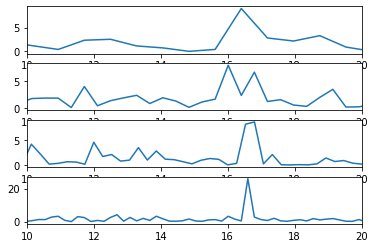

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4)

ax[0].plot(np.fft.rfftfreq( 256, 1/200), dataset1.get_X_features()[80])
ax[1].plot(np.fft.rfftfreq( 512, 1/200), dataset2.get_X_features()[40]) 
ax[2].plot(np.fft.rfftfreq( 750, 1/200), dataset3.get_X_features()[25]) 
ax[3].plot(np.fft.rfftfreq(1024, 1/200), dataset4.get_X_features()[20]) 

ax[0].set_xlim((10,20))
ax[1].set_xlim((10,20))
ax[2].set_xlim((10,20))
ax[3].set_xlim((10,20))

Esta claro que la resolución de frecuencias en el espectrograma de potencias aumenta conforme lo hace el tamaño de la ventana.

Esto se debe al hecho de que, al realizar la tranformada de Fourier sobre un conjunto discreto de datos, la información total se conserva. De esta forma, si nuestro conjunto original contaba con N datos, su transformada de Fourier contará tambien con N datos. 

Ahora bien, la transformada de Fourier de una función en el conjunto de los números reales da como resultado una función compleja (parte real y parte imaginaria), por lo que solo la mitad de los datos nos serán de interes (solo estudiaremos la parte real). Por otro lado, sabemos que para la frecuencia 0 las contribuciones real e imaginaria son idénticas.

Por lo tanto, siendo N par (impar) el número original de datos, la parte real de la tranformada contará con N/2 + 1 (N/2+1/2) datos, equiespaciados entre la frecuencia 0 y la frecuencia de Niquist.

Es decir, la resolución del espectrograma crece linealmente con el tamaño de la ventana.

###b) Teniendo en cuenta el inciso anterior, las frecuencias de estimulación y la frecuencia de muestreo pertinentes, ¿cuál considera que es el número adecuado de muestras temporales que puede recortar conservando la mayor cantidad de información útil en el dominio de la frecuencia? (t).


Intentaremos encontrar ahora el tamaño de ventana óptimo para nuestro problema.

La frecuencia de muestreo es de $200 Hz$ ($1/200$ segundos).

Las estimulaciones tienen una duración aproximada de 10 segundos.

De esta forma, cada estimulación cubre aproximadamente 2000 muestras.

Si consideramos un windows size superior a 2000, estariamos señales provenientes de distintos estímulos, por lo que 2000 es una cota superior del windows size.

Por otro lado, si consideramos un windows size similar a 2000, las muestras que no esten sincronizadas con el estímulo también estarán mezclando información. De esta forma, la cota superior del windows size debe ser algun número claramente inferior a 2000.

Respecto a la resolución, las frecuencias que obtenemos están equiespaciadas entre $0Hz$ y $100Hz$, siendo aproximadamente $N/2$, por lo que la resolución será de $100Hz/(N/2)=200/N Hz$.

Dado que debemos poder distinguir claramente entre los $12.5Hz$ y los $16.5Hz$, una cota inferior para la resolución sería $(16.5Hz-12.5Hz)/10=0.4Hz$, lo que nos deja una cota inferior para el windows size de $N=500$.

Con esto en mente, consideramos que el windows size óptimo esta al rededor de $1024$

###c) En adición a la serie temporal cruda -”complete_examples_signal” de BCIDataset- (concatenada o no a lo largo de los canales, según su elección), defina una estrategia de extracción de atributos en el dominio de tiempo que opere sobre la serie cruda, ejemplo: algún criterio como la media en cada canal para el ejemplo. Sean creativos pero no dediquen mucho tiempo a este inciso, es más bien para tener un punto de comparación.


La serie temporal cruda no brinda por si sola información que permita identificar cual es la estimulación a la que esta siendo expuesto el paciente. Para resolver este problema, debemos procesar los datos y extraer información relevante. 

Con este objetivo, proponemos extraer las propiedades estadísticas de la serie temporal tales como valores mínimo y máximo, media y desviación estandar. Estos valores serán empleados mas adelante para intentar predecir el estado del paciente

In [ ]:
def features_stats(signal_matrix):
    st_fila = []
    for fila in signal_matrix:
        mi  = min(fila)
        ma  = max(fila)
        me = statistics.mean(fila)
        sd = statistics.stdev(fila)
        s = [mi, ma, me, sd]
        st_fila.append(s)

#    st = [0,0,0,0]
#    norma = len(st_fila)
#    for fila in st_fila:
#        st[0] += fila[0]/norma
#        st[1] += fila[1]/norma
#        st[2] += fila[2]/norma
#        st[3] += fila[3]/norma

    return st_fila

In [ ]:
dataset5 = BCIDataset(csvs_path, subject='all', session='all', channel='all', overlapping_fraction=1/2, window_size= 1024, feature_extractor=features_stats)

Processing subject: AA - session: 2...
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: HA - session: 1...
Processing subject: MA - session: 1...


In [ ]:
dataset5.get_X_features()

array([[1495.48      , 1779.4       , 1652.71964844, ..., 1876.18      ,
        1741.83463867,   81.77458769],
       [1520.29      , 1793.77      , 1656.89621094, ..., 1888.44      ,
        1745.9978418 ,   81.75548047],
       [1501.43      , 1807.22      , 1656.51121094, ..., 1901.9       ,
        1745.75318359,   82.57701147],
       ...,
       [ 701.18      ,  847.17      ,  809.61571289, ..., 1391.1       ,
        1347.98606445,    9.8176018 ],
       [ 701.18      ,  862.31      ,  813.39483398, ..., 1391.1       ,
        1348.35681641,   14.83432478],
       [ 788.67      ,  862.31      ,  820.6562207 , ..., 1389.68      ,
        1347.13671875,   13.27719266]])

###d) Guarde los datasets generados de la forma que considere conveniente.


In [ ]:
def ds_to_csv(ds,path):
  df = pd.DataFrame(data=np.hstack((ds.get_X_features(),ds.get_metadata(),ds.get_Y())),
                      index=None,
                      columns=["min_ch0", "max_ch0", "media_ch0", "varianza_ch0",
                               "min_ch1", "max_ch1", "media_ch1", "varianza_ch1",
                               "min_ch2", "max_ch2", "media_ch2", "varianza_ch2",
                               "min_ch3", "max_ch3", "media_ch3", "varianza_ch3",
                               "pureza", "tiempo0", "tiempof", "sujeto", "sesion",
                               "label"]
                      )
  objects = {"pureza", "tiempo0", "tiempof", "sujeto", "sesion"}
  convert_dict=dict()
  for k in df.columns:
    if k not in objects:
      convert_dict[k] = float
    else:
      convert_dict[k] = object

  df = df.astype(convert_dict)

  df.to_csv(path)
  return df

In [ ]:
ds5_df = ds_to_csv(dataset5,"dataframe5.csv")
ds5_df

,min_ch0,max_ch0,media_ch0,varianza_ch0,min_ch1,max_ch1,media_ch1,varianza_ch1,min_ch2,max_ch2,...,min_ch3,max_ch3,media_ch3,varianza_ch3,pureza,tiempo0,tiempof,sujeto,sesion,label
0,1495.48,1779.40,1652.719648,87.974425,481.59,839.39,670.833311,94.884638,1652.68,1854.18,...,1583.87,1876.18,1741.834639,81.774588,True,0.0,5.115,AA,2,99.0
1,1520.29,1793.77,1656.896211,87.653422,500.79,857.12,678.753496,95.857757,1680.17,1864.58,...,1604.24,1888.44,1745.997842,81.755480,True,2.56,7.675,AA,2,99.0
2,1501.43,1807.22,1656.511211,87.940845,500.79,871.68,681.566602,96.753161,1653.14,1875.59,...,1588.03,1901.90,1745.753184,82.577011,True,5.12,10.235,AA,2,99.0
3,1501.43,1807.22,1655.012910,88.161946,499.41,871.68,682.665605,95.272463,1653.14,1875.59,...,1581.10,1901.90,1744.405420,83.219795,True,7.68,12.795,AA,2,99.0
4,1507.86,1795.64,1657.090146,74.089955,499.41,855.01,687.648564,80.214928,1666.34,1853.55,...,1581.10,1884.86,1747.121221,70.201824,True,10.24,15.355,AA,2,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,763.12,839.59,811.586006,12.383983,-57.07,53.96,19.283984,19.181284,1360.96,1402.30,...,1323.14,1369.41,1345.461240,7.144509,False,332.8,337.915,MA,1,2.0
1267,791.47,839.59,817.999111,7.446325,-32.03,53.96,26.254023,10.799232,1364.44,1402.30,...,1330.36,1369.41,1347.169287,6.634014,False,335.36,340.475,MA,1,99.0
1268,701.18,847.17,809.615713,20.999592,-96.55,47.45,13.869395,28.392647,1356.11,1411.84,...,1320.11,1391.10,1347.986064,9.817602,True,337.92,343.035,MA,1,99.0
1269,701.18,862.31,813.394834,24.735704,-96.55,50.69,5.770527,28.455105,1356.11,1411.84,...,1320.11,1391.10,1348.356816,14.834325,True,340.48,345.595,MA,1,99.0


###e) Para cada dataset, analice la contribución de información de cada feature estudiado al propósito de clasificación. Estudie la correlación entre features. Estudie la correlación entre features y etiquetas. En conjunto con la exploración de los TP anteriores, ¿considera útil estos atributos?


En la siguiente tabla se puede ver la correlación de los estadísticos extraidos, tanto entre si como con la etiqueta (label) de la señal, que indica el estado del paciente.

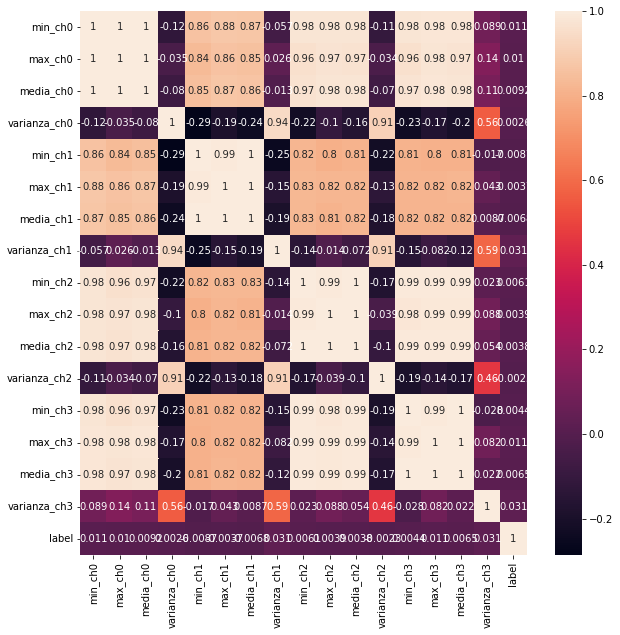

In [ ]:
df = ds5_df.drop(["pureza", "tiempo0", "tiempof", "sujeto", "sesion"],axis=1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ds5_df[ds5_df.label!=99].corr(), annot=True)


Podemos ver que, si bien los estadísticos presentan una buena correlación entre sí, no tienen buena correlación con el label, por lo que dificilmente puedan emplearse para la tarea de predicción.

De esta forma, concluimos que los features extraidos de la serie temporal cruda resultan insuficientes para la predicción del estado del paciente. 

##C) Características Espectrales (en Frecuencia):


###a) Usando BCIDataset, con el extractor de features básico de fft, o el procesador de datos que desee, genere el dataset de ejemplos utilizado como atributos el espectrograma de potencia. Determine la estrategia que considere más pertinente, si concatenar los canales o trabajar los canales en forma individual.


Como vimos en el informe anterior, la tranformada de Fourier de la señal temporal presenta picos característicos en las freciencias de estimulación, por lo que ésta resulta sumamente prometedora en la tarea de predicción.

A continuación mostramos el aspecto característico de la tranformada.

In [ ]:
dataset = BCIDataset(csvs_path, subject='AA', session='0', channel='all', overlapping_fraction=1/2, window_size= 1024, feature_extractor=naif_fft_features)

Processing subject: AA - session: 0...


(0.0, 500.0)

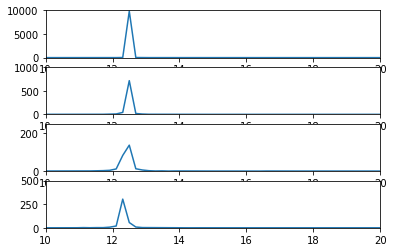

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4)
i = 50
ax[0].plot(np.fft.rfftfreq(1024, 1/200), dataset.get_X_features()[i][0::4])
ax[1].plot(np.fft.rfftfreq(1024, 1/200), dataset.get_X_features()[i][1::4]) 
ax[2].plot(np.fft.rfftfreq(1024, 1/200), dataset.get_X_features()[i][2::4]) 
ax[3].plot(np.fft.rfftfreq(1024, 1/200), dataset.get_X_features()[i][3::4]) 

ax[0].set_xlim((10,20))
ax[1].set_xlim((10,20))
ax[2].set_xlim((10,20))
ax[3].set_xlim((10,20))

ax[0].set_ylim((0,10000))
ax[1].set_ylim((0,1000))
ax[2].set_ylim((0,250))
ax[3].set_ylim((0,500))

Viendo estas imágenes resulta evidente que tiene un potencial predictivo mucho mayor al de la señal temporal cruda.

Resulta mas comodo trabajar con los datos separados para no tener que estar seleccionando los datos cada vez.

###b) En adición, a los vectores de atributos del inciso a), generar dos estrategias adicionales de extracción de features en el dominio de la frecuencia, al menos una de ellas tiene que implicar un número de atributos <= 8. Generar los correspondientes datasets, SEAN CREATIVOS. Si reducen la información a algunas frecuencias específicas, tengan en cuenta que la frecuencia de estimulación puede no encontrarse entre los residuos de frecuencia analizados, o aún si fuera así, que la respuesta al estímulo no sea exactamente de la misma frecuencia del estímulo en sí.


Para mejorar la calidad de los features resultantes y mejorar su análisis, resulta conveniente realizar un preprocesamiento de los datos.

Para empezar normalizaremos los datos. Tomaremos la señal temporal, le restaremos su valo medio y la dividiremos por su varianza. De esta forma, todos los conjuntos de datos estan normalizados, por lo que arrojarán valores con magnitudes similares. 
Restar el valor medio sirve además para deshacernos de las frecuencias bajas, que no resultan de interes. Al dividir por la varianza, las potencias resultantes tendrán valores similares y será mucho mas facil analizarlas.

Una vez normalizados los datos temporales, les realizaremos la tranformada de Fourier. Para esto, aplicaremos un filtro de frecuencias, deshaciendonos de quellas que esten por debajo o por encima de la región de interes. De esta forma, solo consideraremos el espectro entre los $10$ y los $19 Hz$.

In [ ]:
def signal_filter(signal_matrix):

    for i in range(len(signal_matrix)):
        signal_matrix[i] = ( signal_matrix[i] - np.mean(signal_matrix[i]) )  / np.std(signal_matrix[i])

    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 19
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())   

    #for i in range(len(Sxx)):
    #    Sxx[i] = ( Sxx[i] - np.mean(Sxx[i]) )  / np.std(Sxx[i])

    return Sxx

Una vez que la señal este filtrada, procederemos a la extracción de features.

El primer feature que tomaremos será la frecuencia con mayor participación en la señal resultante (es decir, la frecuencia a la cual se da la máxima potencia). Llamaremos a esta frecuencia $f_{max}$. En general, esta está fuertemente correlacionada con el estado del paciente, indicando la frecuencia de estimulación.

Sin embargo, la presencia de ruido puede generar que $f_{max}$ no coincida con la frecuencia de estimulación, por lo que por si sola no ofrece suficiente información.

In [ ]:
def max_freq(signal_matrix):

    N = signal_matrix.shape[1]
    dt = 1/200

    Sxx = signal_filter(signal_matrix) 
    freqs = np.fft.rfftfreq(n=N, d=dt)

    freqs = np.fft.rfftfreq(n=N, d=dt)
    fmax = freqs[Sxx.argmax()]

    return fmax

Definimos el peso ponderado de una frecuencia de interes $f_i$ como la integral de las potencias $P(f)$ alrededor de dicha frecuencia, moduladas por una gaussiana centrada en $f_i$,

$p(f_i)= \frac{1}{p_{max}} \int P(f) exp(-2(f-f_i)^2)  df$.

De esta forma, los pesos ponderados contienen información no solo de la potencia en frecuencia de interés $P(f_i)$, sino tambien información acerca de las potencias en torno a esta, disminuyendo la importancia de estas potencias conforme aumenta la distancia entre las frecuencias.

Para normalizar estos datos, dividimos los valores resultantes por el peso ponderado al rededor de la frecuencia de máxima participación.

$p_{max}=\int P(f) exp(-2(f-f_{max})^2)  df$.



In [ ]:
def p_freq(Sxx,freqs):

    p_125 = 0
    p_165 = 0
    p     = 0

    fmax = freqs[Sxx.argmax()]
    m    = np.mean(Sxx)

    for i in range(len(freqs)):
      f = freqs[i]
      s = Sxx[i]
      p_125 += s*math.exp( -2 * (12.5-f)**2 )
      p_165 += s*math.exp( -2 * (16.5-f)**2 )
      p     += m*math.exp( -2 * (fmax-f)**2 )

   # p = p_125 + p_165
    p_125 = p_125/p
    p_165 = p_165/p

    return p_125, p_165

Finalmente, definimos los valores relativos alrededor de una frecuencia de interes como la potencia de dicha frecuencia dividido por la potencia de la frecuencia de máxima participación.

$v(f_i)=\frac{P(f_i)}{P(f_{max})}$.

In [ ]:
def v_freq(Sxx,freqs):

    v_125 = 0
    v_165 = 0
    v_max = 0

    for i in range(len(freqs)-1):
        f  = freqs[i]
        s  = Sxx[i]
        fn = freqs[i+1]
        sn = Sxx  [i+1]
        if (f == 12.5):
            v_125 = s
        if (f<12.5 and 12.5<fn):
            v_125 = ( (fn-12.5)*s + (12.5-f)*sn ) / (fn - f)
        if (f == 16.5):
            v_165 = s
        if (f<16.5 and 16.5<fn):
            v_165 = ( (fn-16.5)*s + (16.5-f)*sn ) / (fn - f)

    v_max = max(Sxx)

    v_125 = v_125/v_max
    v_165 = v_165/v_max

    return v_125, v_165

In [ ]:
def pro_features(signal_matrix):

    N = signal_matrix.shape[1]
    dt = 1/200

    Sxx = signal_filter(signal_matrix) 
    freqs = np.fft.rfftfreq(n=N, d=dt)

    vpm = []

    for sxx in Sxx:
        fmax = freqs[sxx.argmax()]
        p_125, p_165 = p_freq(sxx,freqs)
        v_125, v_165 = v_freq(sxx,freqs)

        vpm.append([v_125, v_165, p_125, p_165, fmax])    

    return vpm

In [ ]:
dataset6 = BCIDataset(csvs_path, subject='AA', session='0', channel='all', overlapping_fraction=1/2, window_size= 1024, feature_extractor=pro_features)

Processing subject: AA - session: 0...


In [ ]:
dataset6.get_X_features()[6]

array([2.00567789e-01, 2.86116022e-01, 9.18659561e+00, 1.18351073e+01,
       1.54296875e+01, 6.71639179e-03, 8.15709075e-02, 9.91071216e+00,
       6.07099095e+00, 1.30859375e+01, 8.81853337e-04, 5.26290233e-01,
       8.77293697e+00, 1.36606088e+01, 1.15234375e+01, 7.89058925e-02,
       1.47211187e-01, 8.88242039e+00, 7.88884080e+00, 1.54296875e+01])

Processing subject: AA - session: 0...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


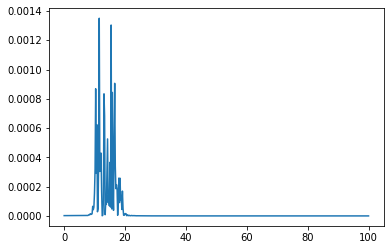

In [ ]:
dataset7 = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size= 1024, feature_extractor=signal_filter)

sns.lineplot(np.fft.rfftfreq(1024, 1/200), dataset7.get_X_features()[6])

Esperamos que estos features sean suficientes para realizar con éxito la tarea de predicción.

###c) Guarde los datasets generados de la forma que considere conveniente.


Los features generados son guardados en datasets para facilitar su utilización mas adelante.

In [ ]:
def ds_to_csv(ds,path):
  df = pd.DataFrame(data=np.hstack((ds.get_X_features(),ds.get_metadata(),ds.get_Y())),
                      index=None,
                      columns=["val_12.5_ch0", "val_16.5_ch0", "p_12.5_ch0", "p_16.5_ch0", "f_max_ch0",
                               "val_12.5_ch1", "val_16.5_ch1", "p_12.5_ch1", "p_16.5_ch1", "f_max_ch1",
                               "val_12.5_ch2", "val_16.5_ch2", "p_12.5_ch2", "p_16.5_ch2", "f_max_ch2",
                               "val_12.5_ch3", "val_16.5_ch3", "p_12.5_ch3", "p_16.5_ch3", "f_max_ch3",
                               "pureza", "tiempo0", "tiempof", "sujeto", "sesion",
                               "label"]
                      )
  objects = {"pureza", "tiempo0", "tiempof", "sujeto", "sesion"}
  convert_dict=dict()
  for k in df.columns:
    if k not in objects:
      convert_dict[k] = float
    else:
      convert_dict[k] = object

  df = df.astype(convert_dict)

  df.to_csv(path)
  return df

In [ ]:
ds6_df = ds_to_csv(dataset6,"dataframe6.csv")
ds6_df

,val_12.5_ch0,val_16.5_ch0,p_12.5_ch0,p_16.5_ch0,f_max_ch0,val_12.5_ch1,val_16.5_ch1,p_12.5_ch1,p_16.5_ch1,f_max_ch1,...,val_16.5_ch3,p_12.5_ch3,p_16.5_ch3,f_max_ch3,pureza,tiempo0,tiempof,sujeto,sesion,label
0,0.309420,0.016829,13.129496,7.945381,11.718750,0.721100,0.086128,18.745804,6.301183,11.328125,...,0.091003,16.550211,8.578752,10.742188,True,0.0,5.115,AA,0,99.0
1,0.397086,0.033375,12.342109,4.756661,15.234375,0.292425,0.063085,23.695040,7.022672,12.109375,...,0.135664,11.102542,11.338848,15.625000,True,2.56,7.675,AA,0,99.0
2,0.445418,0.106829,13.111839,7.435224,14.843750,0.076583,0.279313,14.785651,8.808743,12.109375,...,0.196394,6.783244,12.740112,16.015625,True,5.12,10.235,AA,0,99.0
3,0.191342,0.326868,15.119180,10.667841,11.718750,0.144020,0.118936,13.604901,9.403352,12.109375,...,0.160136,11.098777,10.806556,15.625000,True,7.68,12.795,AA,0,99.0
4,0.719159,0.319439,14.064396,9.543943,11.132812,0.478404,0.216946,9.576571,8.333527,12.304688,...,0.366589,12.216575,10.111653,11.914062,True,10.24,15.355,AA,0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.512214,0.109827,11.731926,5.814082,10.937500,1.000000,0.189139,16.915743,5.691862,12.500000,...,0.332515,12.450073,11.727002,16.796875,False,209.92,215.035,AA,0,2.0
83,0.000059,0.042562,17.730845,4.833441,11.328125,0.282290,0.173920,20.365639,4.384122,14.453125,...,0.300346,17.045635,11.315767,12.109375,False,212.48,217.595,AA,0,1.0
84,0.017331,0.069785,18.311775,5.469018,11.328125,1.000000,0.067207,26.674061,4.231834,12.500000,...,0.440330,16.010066,11.554789,12.695312,True,215.04,220.155,AA,0,1.0
85,0.485792,0.116867,11.659028,6.281810,11.914062,0.961543,0.264185,11.208852,8.921097,10.351562,...,0.414355,6.683341,9.176455,17.773438,True,217.6,222.715,AA,0,1.0


###d) Repita el inciso e) del apartado B). En el caso de los vectores de pocos features realice un pairplot para visualizar en baja dimensionalidad el problema de clasificación.


Veamos ahora como se correlaciónan los featurs extraidos con el estado del paciente.

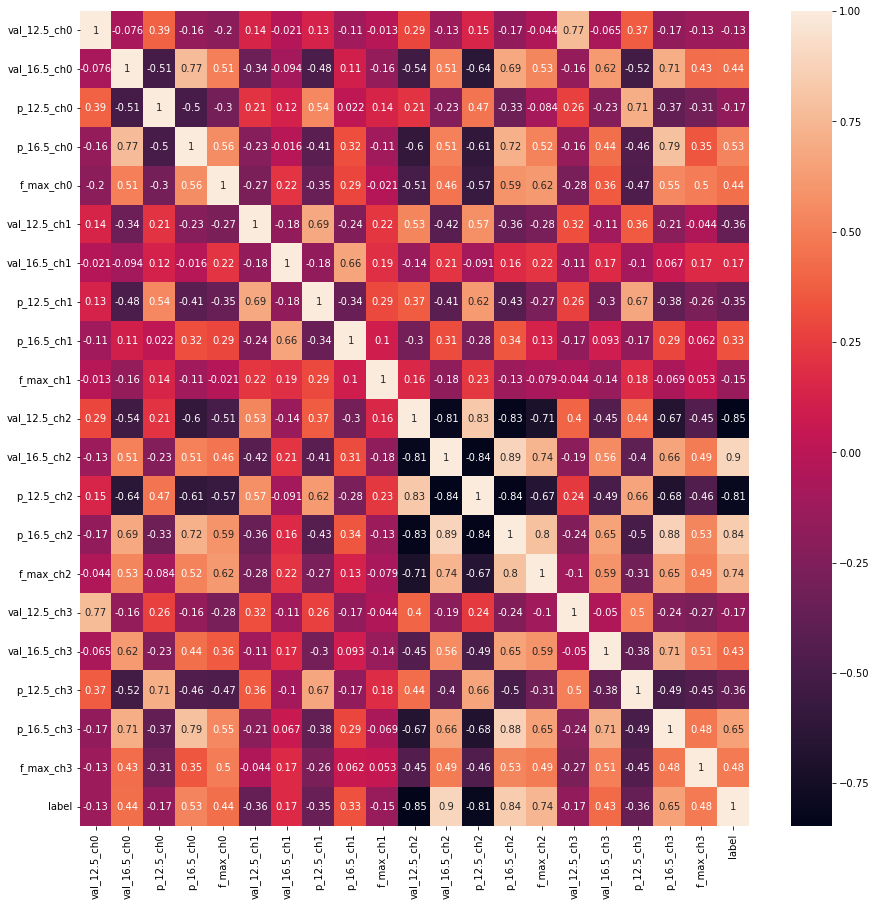

In [ ]:
df = ds6_df.drop(["pureza", "tiempo0", "tiempof", "sujeto", "sesion"],axis=1)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(ds6_df[ds6_df.label!=99].corr(), annot=True)


En la tabla anterior podemos ver que los features no solo presentan una muy buena correlación entre sí, sino que ademas tienen una alta correlación con el label. Esto sugiere fuertemente que son buenos atributos para llevar adelante la tarea de predicción. 

###e) Analice la distribución del dataset, número de ejemplos por clase, balance entre clases, número de ejemplos “puros” y ejemplos “impuros”.


Al analizar el dataset resultante, vemos que existe una buena proporción en los datos generados entre distintas etiquetas y en la pureza de estas.

In [ ]:
ds6_df.label.value_counts()

2.0     31
1.0     30
99.0    26
Name: label, dtype: int64

In [ ]:
ds6_df.pureza.value_counts()

True     46
False    41
Name: pureza, dtype: int64

##D) Particionado del dataset:


In [ ]:
data_all = BCIDataset(csvs_path, overlapping_fraction=1/4, window_size= 1240, feature_extractor=pro_features)

Processing subject: AA - session: 2...
Processing subject: AA - session: 0...
Processing subject: AA - session: 1...
Processing subject: JA - session: 1...
Processing subject: JA - session: 2...
Processing subject: HA - session: 1...
Processing subject: MA - session: 1...


###a) A partir de los datasets generados en los apartados B) y C), definir un esquema de particionado (train, validation, test) apropiado para el entrenamiento de un algoritmo de clasificación. Tener en cuenta:


####i) Frecuencias de cada una de las clases y balanceo.


####ii) Inclusión de etiquetas puras e impuras.


####iii) Influencia del solapamiento en la independencia de los conjuntos.


####iv) Porcentaje de la base total que se considera en cada conjunto.


####v) Tener en cuenta la influencia de los diferentes pacientes y sesiones. ¿Qué estrategia prioriza? Utilizar todos los pacientes y validar/testear sobre conjuntos definidos teniendo en cuenta esa variable. O tener un conjunto de validación/testeo completamente independiente formado por otro paciente.


####vi) Fundamente todas las decisiones tomadas.

Una vez generado el dataset, procedemos a dividirlo en conjuntos de entrenamiento, evaluación y validación.

Decidimos emplear un $80\%$ de los datos en el conjunto de entrenamiento, mientras que los datos restantes se dividiran en partes iguales de un $10\%$ para los conjuntos de evaluación y validación. Para esta desición nos basamos en las proporciones estandar que se suelen tomar en este tipo de problemas.

Es posible ver que cada conjunto contiene proporciones similares de datos correspondientes a cada clase y propociones similares de pureza, con lo que concluimos que los datos están bien valaceados. 

La influencia del solapamiento ya fue discutida anteriormente. Este genera que exista cierta correlación entre los datos, pero permite también incrementar el número de muestras.

Consideraremos para el dataset de predicción los datos correspondientes a todos los pasientes, en todas sus sesiones y de todos sus canales, para contar con el conjunto mas amplio y heterogeneo posible.

In [ ]:
data = np.hstack((data_all.get_X_features(), data_all.get_Y()))

In [ ]:
data_cleaned = data[data[:,-1]!=99]

In [ ]:
from sklearn.model_selection import train_test_split
X, y = data_cleaned[:,:-1],data_cleaned[:,-1]
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, train_size=0.5, random_state=0)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

#X_train

((659, 20), (82, 20), (83, 20), (659,), (82,), (83,))

In [ ]:
for d in [y_train,y_test,y_val]:
  print(np.unique(d, return_counts=True))

(array([1., 2.]), array([320, 339]))
(array([1., 2.]), array([39, 43]))
(array([1., 2.]), array([39, 44]))


In [ ]:
X_train

array([[ 0.40866213,  0.49790355, 17.24612151, ..., 12.15093199,
        16.13617859, 11.77419355],
       [ 0.29447291,  0.06284216, 16.75144403, ..., 31.74917802,
         3.91889532, 12.58064516],
       [ 0.18937707,  0.51983691,  7.62948426, ...,  6.88459983,
        21.8089355 , 16.61290323],
       ...,
       [ 0.07888027,  0.21043387, 15.62043685, ..., 14.39330429,
        10.59999328, 11.77419355],
       [ 0.72094088,  0.06495657, 18.23666554, ..., 29.85880794,
         5.6381833 , 12.58064516],
       [ 0.35235067,  0.05525234, 12.40529533, ..., 16.04648673,
        10.23270954, 11.93548387]])

# **Aprendizaje automático**

El objetivo de este trabajo práctico no es evaluar y comparar diferentes algoritmos de clasificación, sino entender el problema de clasificación en su conjunto y definir el esquema general para trabajar en él. En ese sentido:

##A) Entendimiento del problema.


###a) Está claro que hasta aquí hablamos de un problema de clasificación supervisada, pero ¿a qué subclase dentro de ellos pertenece? (multilabel? multiclase?)


Se trata de un problema multiclase, ya que se clasifican en clases disjuntas dependiendo del tipo de estimulacion.

###b) En palabras, describa cómo podría plantearse un problema de regresión con los datos estudiados.


Por ejemplo, se podria tomar el feature que implica la probabilidad de que la estimulacion sea de tipo 1 y tipo 2 y tomarlos como puntos de un plano y aplicar una regresion lineal para buscar dividir los puntos en las dos clases.

###c) De la misma forma, ¿cómo podría pensarse un problema de clasificación no supervisada a partir de los datos disponibles?


En este caso se pueden tomar todos los features y analizarlas utilizando el algoritmo K-Means para dividirlas en dos grupos, buscando que se correspondan con la clase 1 y 2 de estimulacion.

##B) En el problema de clasificación supervisada:


###a) ¿Qué métricas considera que son apropiadas para evaluar el desempeño de algún algoritmo de clasificación?


Para evaluar el desempeño de los algoritmos utilizamos la matriz de confusion y el f1-score.

###b) ¿Qué funciones de costo consideran apropiadas para entrenar un algoritmo para este problema?


Dado que cada funcion de costo, se comportan distinto en cada algoritmo, utilizamos las funciones de costo estandar para cada algortmo.

##C) Seleccione un algoritmo de aprendizaje supervisado estudiado en la Diplomatura.


###a) Elija uno de los datasets generados previamente.


In [ ]:
def to_numerical(vector):
  result = vector.copy()
  result[result == 99] = 0
  result[result == 1] = -1
  result[result == 2] = 1
  return result

In [ ]:
y_train_e = to_numerical(y_train)
y_test_e = to_numerical(y_test)
y_val_e = to_numerical(y_val)

###b) Determine un benchmark de performance usando una asignación aleatoria de etiquetas.


In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_train, y_train)


DummyClassifier(strategy='uniform')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


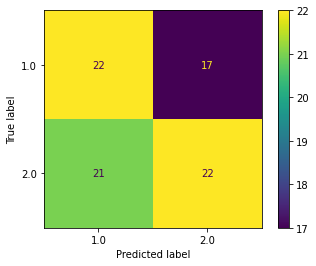

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
plot_confusion_matrix(dummy_clf,X_test,y_test)
plt.show()

In [ ]:
y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.47      0.46      0.47        39
         2.0       0.52      0.53      0.53        43

    accuracy                           0.50        82
   macro avg       0.50      0.50      0.50        82
weighted avg       0.50      0.50      0.50        82



###c) Entrene el algoritmo seleccionado, (no invertir mucho tiempo en el ajuste de hiperparámetros).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

###d) Genere curvas de la evolución de las métricas relevantes a lo largo del entrenamiento (desempeño y loss), tanto para el conjunto de entrenamiento como de validación. Analice la presencia de los fenómenos de overfitting, underfitting, y su relación con el bias y variance.


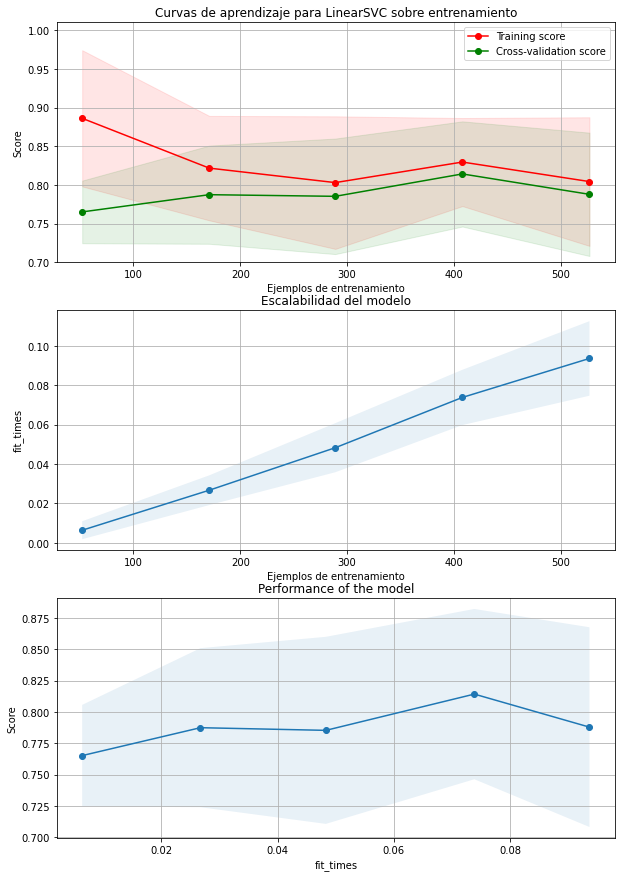

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Ejemplos de entrenamiento")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Ejemplos de entrenamiento")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Escalabilidad del modelo")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Curvas de aprendizaje para LinearSVC sobre entrenamiento"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearSVC()
plot_learning_curve(
    estimator,
    title,
    X_train,
    y_train,
    axes=axes,
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="accuracy",
)

#title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
#plot_learning_curve(
#    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
#)

plt.show()

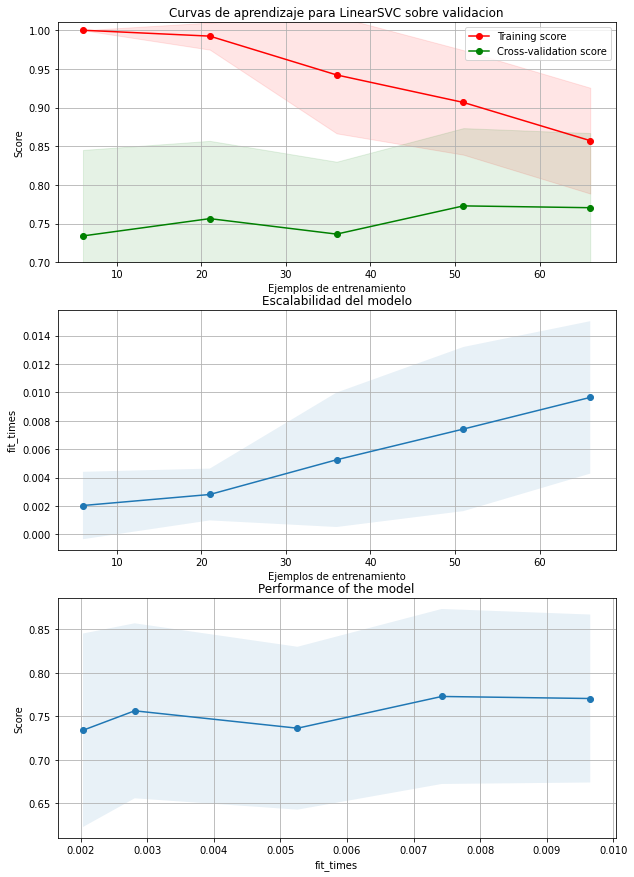

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Curvas de aprendizaje para LinearSVC sobre validacion"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearSVC()
plot_learning_curve(
    estimator,
    title,
    X_val,
    y_val,
    axes=axes,
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="accuracy",
)

#title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
#plot_learning_curve(
#    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
#)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


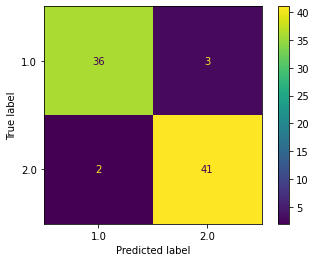

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
plot_confusion_matrix(clf,X_test,y_test)
plt.show()

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.95      0.92      0.94        39
         2.0       0.93      0.95      0.94        43

    accuracy                           0.94        82
   macro avg       0.94      0.94      0.94        82
weighted avg       0.94      0.94      0.94        82



###K-means

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)
#kmeans.cluster_centers_

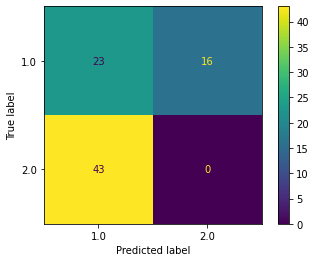

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = (1-kmeans.predict(X_test)) + 1 # las clases son 0 y 1 originalmente
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.35      0.59      0.44        39
         2.0       0.00      0.00      0.00        43

    accuracy                           0.28        82
   macro avg       0.17      0.29      0.22        82
weighted avg       0.17      0.28      0.21        82



####Random forest GBDT

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=1/2, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


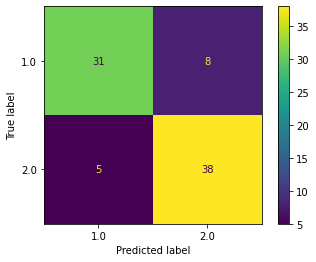

In [ ]:
plot_confusion_matrix(gb_clf2,X_test,y_test)
plt.show()

In [ ]:
y_pred = gb_clf2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.86      0.79      0.83        39
         2.0       0.83      0.88      0.85        43

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82



###e) Sobre el conjunto de test, utilice las métricas definidas en el apartado B-a) para determinar el desempeño del algoritmo. Compárelo con el benchmark de desempeño.


Es evidente que el algoritmo LinearSVC es mucho mejor que nuestro benchmark ya que el f1-score en el algoritmo Dummy da 0.51 mientras que con LinearSVC da 0.90.
Por otro lado en las dos matrices de confusion se nota claramente que el algoritmo Dummy acierta el 50% de las veces mientras que LinearSVC acierta en la gran mayoria de las veces.

##D) Teniendo en cuenta lo observado en el apartado C), entrene el mismo algoritmo en todos los datasets generados previamente (5 en total). Use siempre el mismo esquema de particiones (los 5 datasets deberían ser diferentes features de los mismos ejemplos en el dominio del tiempo).


###a) Compare el desempeño del algoritmo sobre el conjunto de test.


###b) ¿Qué influencia tienen los features elegidos sobre el algoritmo utilizado?

Los features a elegir tienen mucha influencia ya que necesitamos encontrar features que esten fuertemente correlacionados con las clases a clasificar.

# Matriz de correlacion para el video

In [ ]:
data_all_video = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size= 1024, feature_extractor=pro_features)

df = pd.DataFrame(data=np.hstack((data_all_video.get_X_features(),data_all_video.get_Y())),
                      index=None,
                      columns=["val_12.5", "val_16.5", "p_12.5", "p_16.5", "f_max", "label"])

df = df[df.label!=99]

df

Processing subject: AA - session: 0...


,val_12.5,val_16.5,p_12.5,p_16.5,f_max,label
17,0.039038,0.514128,6.462428,23.356898,16.601562,2.0
18,0.257681,0.535076,14.782525,25.150201,16.601562,2.0
19,0.556955,0.493398,16.621409,26.680796,16.601562,2.0
20,0.101279,0.489960,10.601411,32.944124,16.601562,2.0
22,0.438929,0.116619,10.281111,7.105237,13.671875,1.0
...,...,...,...,...,...,...
82,1.000000,0.421464,16.398956,12.033888,12.500000,2.0
83,0.443935,0.136466,28.066391,7.176810,12.695312,1.0
84,1.000000,0.051759,32.523306,5.926541,12.500000,1.0
85,1.000000,0.034759,26.763883,4.571620,12.500000,1.0


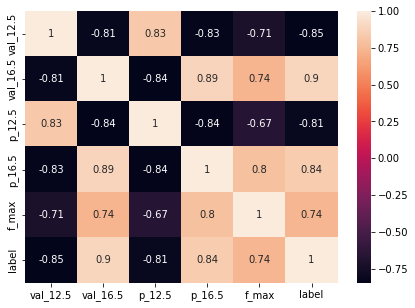

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(df.corr(), annot=True)

In [ ]:
dataset10 = BCIDataset(csvs_path, subject='AA', session='0', channel='ch2', overlapping_fraction=1/2, window_size= 4500, feature_extractor=filtered_fft_features)

Processing subject: AA - session: 0...


(10.0, 20.0)

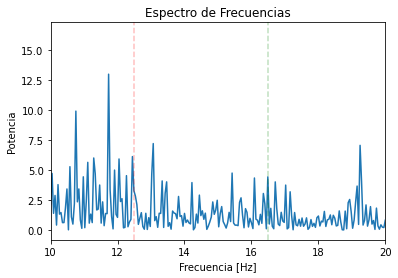

In [ ]:
fig, ax = plt.subplots(1)

ax.set_xlabel("Frecuencia [Hz]")
ax.set_ylabel("Potencia")
ax.set_title("Espectro de Frecuencias")

ax.plot(np.fft.rfftfreq( 4500, 1/200), dataset10.get_X_features()[0])

ax.axvline(12.5, color='r', linestyle='--',alpha=0.25, label="12.5Hz")
ax.axvline(16.5, color='g', linestyle='--',alpha=0.25, label="16.5Hz")

ax.set_xlim((10,20))